<a href="https://colab.research.google.com/github/jordantangy/MoviePosterClassification-CNN/blob/main/ConvNet_Movie_Poster_Classification_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.0.0-rc0

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

##**Import dataset and show its content**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/duplicate_free_41K.csv')
truncat = data[:30000]
truncat

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,30023,https://m.media-amazon.com/images/M/MV5BMTU1Nj...,A Mother's Nightmare,2012,6.0,"crime, mystery, thriller",0,0,0,0,1,0,0,0,1,0,0,0,1
29996,30024,https://m.media-amazon.com/images/M/MV5BMTQ3Mz...,SheZow,2012,6.0,"animation, action, adventure",1,1,1,0,0,0,0,0,0,0,0,0,0
29997,30025,https://m.media-amazon.com/images/M/MV5BNDNkN2...,The Seven Year Hitch,2012,6.0,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
29998,30026,https://m.media-amazon.com/images/M/MV5BNjg5ZD...,Onii-chan Dakedo Ai Sae Areba Kankei Nai yo ne-,2012,6.0,animation,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
!unzip /content/drive/MyDrive/img_41K.zip

##**Insertion of the pictures into a managable array**

In [6]:
pic_width = 224
pic_height = 224
X_train = []
X_test = []
X_val = []
for i in tqdm(range(int(truncat.shape[0]))):
  if i < int(truncat.shape[0]*0.60)-1 :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_train.append(img)
  elif i > int(truncat.shape[0]*0.60)-1 and i < int(truncat.shape[0]*0.8)-1 :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_test.append(img)
  else :
    path = '/content/img_41K/'+ str(data['id'][i]) +'.jpg'
    img = image.load_img(path, target_size=(pic_width,pic_height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X_val.append(img)

100%|██████████| 30000/30000 [01:39<00:00, 303.00it/s]


In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

##**Example of a poster from the DataSet and its corresponding genre**

'comedy, sci-fi, thriller'

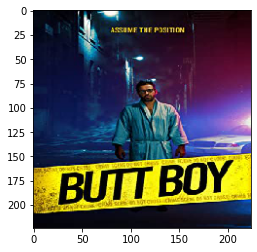

In [8]:
plt.imshow(X_train[5475])
data['genre'][5475]

In [21]:
#matrix y comes from the csv file, we just drop the column id and genre.
#So we have a matrix representing which genre each movie belongs to

y = truncat.drop(['id','poster','title','year','rating','genre'], axis = 1)
y = y.to_numpy()

##**Splitting the dataset into train set and test set**

In [10]:
train_size = int(X_train.shape[0])
test_size = int(X_test.shape[0])

In [11]:
y_train = []
y_test = []
y_val = []
for i in range(train_size):
  y_train.append(y[i])
y_train = np.array(y_train)

for i in range(train_size,train_size+test_size):
  y_test.append(y[i])
y_test = np.array(y_test)

for i in range(train_size+test_size,30000):
  y_val.append(y[i])
y_val = np.array(y_val)

##**Building the CNN Model**

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape = X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))


model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())



model.add(Dense(13, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0

##**Compilation**

In [13]:
model.compile(optimizer="adam", loss = 'binary_crossentropy', metrics=['accuracy'])

##**Start training**

In [14]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val) , callbacks=[callback],batch_size= 100)

Train on 17999 samples, validate on 6002 samples
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
17999/17999 [==============================] - 204s 11ms/sample - loss: 0.5458 - accuracy: 0.7479 - val_loss: 1.0789 - val_accuracy: 0.6845
Epoch 2/20
17999/17999 [==============================] - 201s 11ms/sample - loss: 0.3919 - accuracy: 0.8384 - val_loss: 0.6423 - val_accuracy: 0.7805
Epoch 3/20
17999/17999 [==============================] - 202s 11ms/sample - loss: 0.3772 - accuracy: 0.8432 - val_loss: 0.4452 - val_accuracy: 0.8164
Epoch 4/20
17999/17999 [==============================] - 202s 11ms/sample - loss: 0.3607 - accuracy: 0.8489 - val_loss: 0.4702 - val_accuracy: 0.8100


##**Plot the values obtained during the training session**

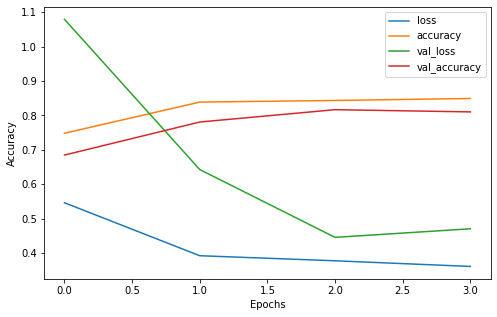

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

##**Evaluating the model**

In [19]:
#Testing the model on the test set

ev = model.evaluate(X_test,y_test)

5999/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [20]:
loss = str(int(round(ev[0],2)*100))+'%'
accuracy = str(int(round(ev[1],2)*100))+'%'
print("Testing the model on 6000 samples gives a loss of ", loss , " and an accuracy of ",accuracy)

Testing the model on 6000 samples gives a loss of  54%  and an accuracy of  80%


##**A few examples of testing**

In [ ]:
img = image.load_img('/content/8effb44395f86988a83259473102fc2e6cdc43def49da9bfa3ac600d04708c63._RI_V_TTW_.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Nightmare' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'horror', hence the network succeeded")

In [ ]:
img = image.load_img('/content/action_poster.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'War' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'action', hence the network succeeded")

In [ ]:
img = image.load_img('/content/love-romance-chocolate-movie-poster-md.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Love, Romance and Chocolate' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'romance', hence the network succeeded")

In [ ]:
img = image.load_img('/content/sci-fi-fantasy_0017_ebay_listing.jpg', target_size=(pic_width,pic_height, 3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1, pic_width, pic_height, 3)

genres = data.columns[6:]
y_prob = model.predict(img)
arr = np.array(y_prob)
top2 = np.argsort(y_prob[0])
print("The 2 genres predicted for the Movie Poster 'Avatar' are :")
for i in range(11,13):
  index = top2[i]
  print(genres[index])
print("The expected output was at least 'sci-fi', but it doesn't appear, hence the network didn't succeed to predict the right genre")